# The Skeptical Orc: Attention-Based MIL System (Upgraded)

**Goal:** Classify Histology Slides with Noisy Labels.
**Method:** Multiple Instance Learning (MIL) with Gated Attention and Domain-Specific Pre-training.

### Workflow:
1.  **Ingest:** Group pre-cut patches into "Bags" (Patients).
2.  **Warm-Up (Phase 1):** Pre-train the encoder on patches using weak labels to learn histology textures.
3.  **Extract (Phase 2):** Use the custom "Smart" EfficientNetB0 to convert images to Feature Vectors.
4.  **Visualize (t-SNE):** Check if the clusters have improved.
5.  **Poison Control (Phase 3):** 
    * **Audit:** Train briefly with **Generalized Cross Entropy (GCE)** .
    * **Purge:** Identify and remove patients with consistently high loss (likely mislabeled).
    * **Retrain:** Train the final Gated Attention Network on the cleaned data.
6.  **Diagnose:** Validate with Attention Heatmaps.

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Setup Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

Using device: cuda


In [2]:
# --- CONFIGURATION ---
DATA_DIR = os.path.join("..", "an2dl2526c2")
PATCHES_DIR = os.path.join(DATA_DIR, "train_patches")
LABELS_FILE = os.path.join(DATA_DIR, "train_labels.csv")

# Hyperparameters
BATCH_SIZE = 1  # In MIL, Batch Size = 1 Bag (1 Patient)
GRAD_ACCUMULATION_STEPS = 32 # Gradient Accumulation for stability
LR = 1e-4
EPOCHS = 30
DROPOUT_RATE = 0.5 
# LABEL_SMOOTHING removed here as GCE handles noise better

## 1. Data Parsing
Group patches by patient ID.

In [3]:
# Load Labels
try:
    df_labels = pd.read_csv(LABELS_FILE)
    # Clean IDs and Map Labels
    df_labels['clean_id'] = df_labels['sample_index'].astype(str).str.replace('.png', '', regex=False)
    
    label_map = {
        'Luminal A': 0,
        'Luminal B': 1,
        'HER2(+)': 2,
        'Triple negative': 3
    }
    
    df_labels['label_idx'] = df_labels['label'].map(label_map)

except FileNotFoundError:
    print("ERROR: Labels file not found. Please check paths.")

# Scan Patches Folder
all_patch_paths = glob.glob(os.path.join(PATCHES_DIR, "*.png")) 

# Group Patches by Patient ID
patient_bags = {}
for path in all_patch_paths:
    filename = os.path.basename(path)
    patient_id = "_".join(filename.split("_")[:2]) 
    
    if patient_id not in patient_bags:
        patient_bags[patient_id] = []
    patient_bags[patient_id].append(path)

# Link Labels to Bags
valid_bags = []
labels_list = []
patient_ids_list = []

for pid, paths in patient_bags.items():
    row = df_labels[df_labels['clean_id'] == pid]
    if not row.empty and not pd.isna(row['label_idx'].values[0]):
        lbl = row['label_idx'].values[0]
        valid_bags.append(paths)
        labels_list.append(int(lbl))
        patient_ids_list.append(pid)

print(f"Total Labeled Patients: {len(valid_bags)}")

Total Labeled Patients: 1261


## 2. The Split (Train / Val / Test)
Splitting by Patient to prevent data leakage.

In [4]:
X_train_val, X_test, y_train_val, y_test, id_train_val, id_test = train_test_split(
    valid_bags, labels_list, patient_ids_list, test_size=0.15, stratify=labels_list, random_state=SEED
)

X_train, X_val, y_train, y_val, id_train, id_val = train_test_split(
    X_train_val, y_train_val, id_train_val, test_size=0.176, stratify=y_train_val, random_state=SEED 
)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

Train: 882 | Val: 189 | Test: 190


## Phase 1: The Warm-Up (Weakly Supervised Pre-training)
We train the feature extractor to recognize histology textures *before* using it for MIL. We assume every patch has the patient's label.

In [5]:
# --- 1.1 Create Patch-Level Dataset ---
class PatchLevelDataset(Dataset):
    def __init__(self, bags_list, labels_list, transform=None):
        self.data = []
        # Flatten the bags: (Patient_Bag, Label) -> [(Patch1, Label), (Patch2, Label)...]
        for bag_paths, label in zip(bags_list, labels_list):
            for path in bag_paths:
                self.data.append((path, label))
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        path, label = self.data[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Strong Augmentation for Pre-training
stats = ((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# --- 1.2 Class Balancing (Weighted Sampler) ---
# Create dataset without transform first to count labels efficiently or just use the flattening logic
flat_labels = []
for bag, lbl in zip(X_train, y_train):
    flat_labels.extend([lbl] * len(bag))

class_counts = np.bincount(flat_labels)
print(f"Patch Class Counts: {class_counts}")

class_weights = 1. / class_counts
sample_weights = [class_weights[l] for l in flat_labels]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

patch_train_dataset = PatchLevelDataset(X_train, y_train, transform=train_transform)
patch_train_loader = DataLoader(patch_train_dataset, batch_size=32, sampler=sampler, num_workers=0)

# --- 1.3 Initialize Encoder for Training ---
print("Initializing Encoder for Warm-Up...")
encoder = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Replace Head with 4-class classifier (NOT Freezing weights)
encoder.classifier[1] = nn.Linear(1280, 4)
encoder = encoder.to(device)

# --- 1.4 Pre-training Loop ---
optimizer_enc = optim.Adam(encoder.parameters(), lr=1e-4)
criterion_enc = nn.CrossEntropyLoss()

print("Starting Weakly Supervised Pre-training (5 Epochs)...")
encoder.train()
for epoch in range(5):
    running_loss = 0.0
    for images, labels in tqdm(patch_train_loader, desc=f"Warm-Up Epoch {epoch+1}"):
        images, labels = images.to(device), labels.to(device)
        
        optimizer_enc.zero_grad()
        outputs = encoder(images)
        loss = criterion_enc(outputs, labels)
        loss.backward()
        optimizer_enc.step()
        running_loss += loss.item()
    
    print(f"Epoch {epoch+1} Avg Loss: {running_loss / len(patch_train_loader):.4f}")

# Save the Smart Weights
torch.save(encoder.state_dict(), "models/smart_histology_encoder.pth")
print("Saved 'smart_histology_encoder.pth'. Phase 1 Complete.")

# Clean up to save VRAM
del encoder, optimizer_enc, patch_train_loader
torch.cuda.empty_cache()

Patch Class Counts: [1085 1359 1023  477]
Initializing Encoder for Warm-Up...
Starting Weakly Supervised Pre-training (5 Epochs)...


Warm-Up Epoch 1: 100%|██████████| 124/124 [00:55<00:00,  2.24it/s]


Epoch 1 Avg Loss: 1.3335


Warm-Up Epoch 2: 100%|██████████| 124/124 [00:43<00:00,  2.83it/s]


Epoch 2 Avg Loss: 1.2067


Warm-Up Epoch 3: 100%|██████████| 124/124 [00:38<00:00,  3.19it/s]


Epoch 3 Avg Loss: 1.0579


Warm-Up Epoch 4: 100%|██████████| 124/124 [00:34<00:00,  3.57it/s]


Epoch 4 Avg Loss: 0.9124


Warm-Up Epoch 5: 100%|██████████| 124/124 [00:35<00:00,  3.47it/s]


Epoch 5 Avg Loss: 0.8117
Saved 'smart_histology_encoder.pth'. Phase 1 Complete.


## Phase 2: Modify Feature Extraction (The "Frozen Eye")
We now load the custom weights we just trained, remove the head, and use it to extract features.

In [6]:
# Define Transforms (Normalization only for extraction)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(*stats)
])

# --- 2.1 Update Model Initialization ---
# Initialize with random weights first
feature_extractor = models.efficientnet_b0(weights=None)

# --- 2.2 Modify Head BEFORE Loading Weights ---
# We must match the architecture of the saved model (Linear 1280->4)
feature_extractor.classifier[1] = nn.Linear(1280, 4)

# Load Custom Weights
print("Loading smart histology weights...")
feature_extractor.load_state_dict(torch.load("models/smart_histology_encoder.pth", map_location=device))

# --- 2.3 The Lobotomy (Remove Head) ---
feature_extractor.classifier = nn.Identity()
feature_extractor.to(device)
feature_extractor.eval()

def precompute_features(bags_list, labels_list, ids_list):
    processed_data = []
    print("Pre-computing features with Smart Encoder...")
    
    with torch.no_grad():
        for i, (bag_paths, label, pid) in enumerate(zip(tqdm(bags_list), labels_list, ids_list)):
            if len(bag_paths) == 0: continue
            
            images = []
            for p in bag_paths:
                try:
                    img = Image.open(p).convert('RGB')
                    img = val_transform(img)
                    images.append(img)
                except:
                    pass 
            
            if len(images) == 0: continue
            
            img_batch = torch.stack(images).to(device)
            
            # Batch inference logic
            if len(img_batch) > 128:
                features_list = []
                for split in torch.split(img_batch, 128):
                    f = feature_extractor(split)
                    features_list.append(f.cpu())
                features = torch.cat(features_list)
            else:
                features = feature_extractor(img_batch).cpu()
                
            processed_data.append({
                'features': features, 
                'label': label,
                'id': pid,
                'paths': bag_paths 
            })
    return processed_data

# Run extraction
train_data_ready = precompute_features(X_train, y_train, id_train)
val_data_ready = precompute_features(X_val, y_val, id_val)
test_data_ready = precompute_features(X_test, y_test, id_test)

C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_49804\4162159689.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  feature_extractor.load_state_dict(torch.load("models/s

Loading smart histology weights...
Pre-computing features with Smart Encoder...


100%|██████████| 882/882 [00:25<00:00, 34.83it/s]


Pre-computing features with Smart Encoder...


100%|██████████| 189/189 [00:14<00:00, 13.36it/s]


Pre-computing features with Smart Encoder...


100%|██████████| 190/190 [00:12<00:00, 14.76it/s]


## 4. Visual Diagnostic: t-SNE
Checking if the "Smart" encoder separated the clusters better than the Generic one.

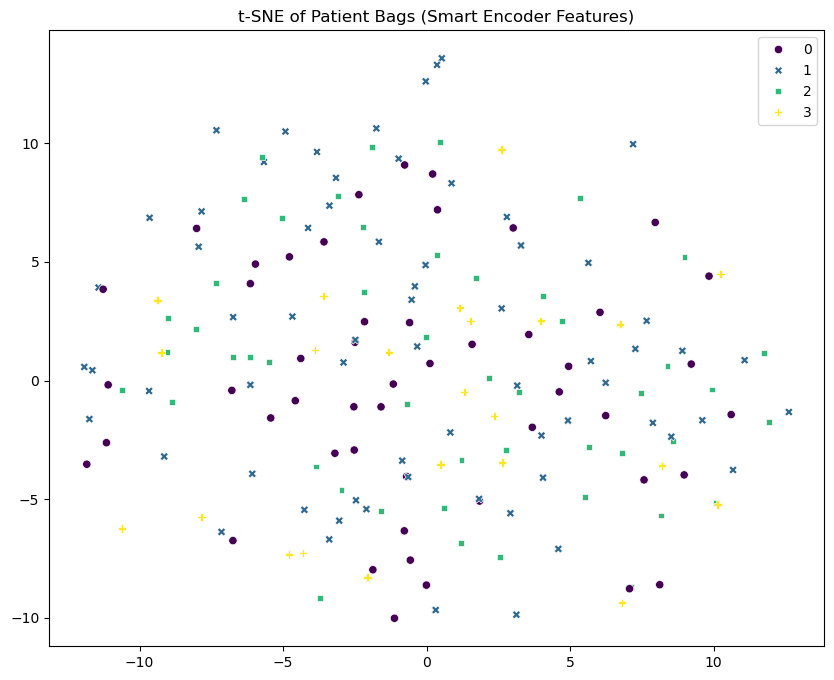

In [10]:
all_feats = []
all_lbls = []

for item in val_data_ready:
    f = item['features']
    l = item['label']
    mean_feat = torch.mean(f, dim=0)
    all_feats.append(mean_feat.numpy())
    all_lbls.append(l)

tsne = TSNE(n_components=2, perplexity=30, random_state=SEED)
feats_embedded = tsne.fit_transform(np.array(all_feats))

plt.figure(figsize=(10, 8))
sns.scatterplot(x=feats_embedded[:,0], y=feats_embedded[:,1], hue=all_lbls, palette='viridis', style=all_lbls)
plt.title("t-SNE of Patient Bags (Smart Encoder Features)")
plt.show()

## Phase 3: Upgrade MIL Architecture (The "Skeptical Orc")
Implementing **Gated Attention** to better capture non-linear relationships.

In [11]:
class OrcAttentionModel(nn.Module):
    def __init__(self, num_classes=4, input_dim=1280, dropout=0.5, hidden_dim=512):
        super().__init__()
        
        # --- 3.1 Gated Attention Mechanism ---
        # Branch V: Tanh activation (Feature learning)
        self.attention_V = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh()
        )
        
        # Branch U: Sigmoid activation (Gating mechanism)
        self.attention_U = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Sigmoid()
        )
        
        # Final calculation to get score
        self.attention_weights = nn.Linear(hidden_dim, 1)
        
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, num_classes)
        )

    def forward(self, bag_features):
        # bag_features: (N_patches, 1280)
        
        # A. Calculate Gated Attention Scores
        # A_V = Tanh(W_v * H)
        A_V = self.attention_V(bag_features)  # N x 512
        # A_U = Sigmoid(W_u * H)
        A_U = self.attention_U(bag_features)  # N x 512
        
        # Element-wise multiplication, then project to 1 score
        # scores = W * (A_V * A_U)
        raw_scores = self.attention_weights(A_V * A_U).squeeze(-1) # N
        
        # B. Softmax
        weights = torch.softmax(raw_scores, dim=0)
        
        # C. Weighted Average
        slide_embedding = torch.sum(bag_features * weights.unsqueeze(-1), dim=0)
        
        # D. Classification
        logits = self.classifier(slide_embedding)
        
        return logits, weights

## 6. The "Poison Control" Protocol (GCE + Purge)
To handle noisy labels, we use the **O2U (Online Uncertainty)** strategy.
1.  **Robust Loss:** We replace CrossEntropy with **Generalized Cross Entropy (GCE)** to prevent overfitting to noise.
2.  **Audit (Round 1):** Train briefly to find patients the model "hates" (high loss).
3.  **Purge:** Remove the top 20% high-loss patients.
4.  **Final Train (Round 2):** Train from scratch on the clean dataset.

In [12]:
# Dataset Wrapper
class RAMDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

def mil_collate(batch):
    return batch[0]

# Calculate Class Weights for the Bags
bag_class_counts = np.bincount(y_train)
bag_weights = 1. / bag_class_counts
bag_weights = bag_weights / bag_weights.sum() * len(bag_class_counts)
bag_class_weights = torch.FloatTensor(bag_weights).to(device)

# --- STEP 3: ROBUST LOSS FUNCTION (GCE) ---
class GeneralizedCrossEntropy(nn.Module):
    def __init__(self, q=0.7, weight=None):
        super().__init__()
        self.q = q
        self.weight = weight
        
    def forward(self, logits, targets):
        # Ensure logits has batch dimension
        if logits.dim() == 1:
            logits = logits.unsqueeze(0)
        # targets should be a single scalar tensor for this batch
        p = torch.softmax(logits, dim=-1)
        # Select the probability of the true class
        p_true = p[torch.arange(p.shape[0]), targets]
        
        if self.weight is not None:
             w = self.weight[targets]
             loss = (1 - (p_true ** self.q)) / self.q * w
        else:
             loss = (1 - (p_true ** self.q)) / self.q
             
        return loss.mean()

# --- STEP 2: THE POISON CONTROL PROTOCOL ---

# Setup
PURGE_PERCENTILE = 0.20 # Drop top 20% dirtiest data
WARMUP_EPOCHS = 10      # Audit duration

# 1. Initialize "Audit" Model
print(f"--- ROUND 1: AUDIT (Identifying Poison) ---")
audit_model = OrcAttentionModel(dropout=DROPOUT_RATE).to(device)
optimizer = optim.AdamW(audit_model.parameters(), lr=LR, weight_decay=1e-3)
criterion = GeneralizedCrossEntropy(q=0.7, weight=bag_class_weights)

train_loader = DataLoader(RAMDataset(train_data_ready), batch_size=1, shuffle=True, collate_fn=mil_collate)

# 2. Audit Training Loop
audit_model.train()
for epoch in range(WARMUP_EPOCHS):
    running_loss = 0.0
    optimizer.zero_grad()
    
    for i, batch_data in enumerate(train_loader):
        feats = batch_data['features'].to(device)
        label = torch.tensor([batch_data['label']]).long().to(device)
        
        logits, _ = audit_model(feats)
        loss = criterion(logits, label)
        
        loss = loss / GRAD_ACCUMULATION_STEPS
        loss.backward()
        running_loss += loss.item() * GRAD_ACCUMULATION_STEPS
        
        if (i + 1) % GRAD_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
            
    print(f"Audit Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f}")

# 3. The Purge
print("Calculating losses for all training samples...")
audit_model.eval()
train_losses_audit = []

with torch.no_grad():
    for item in train_data_ready:
        feats = item['features'].to(device)
        label = torch.tensor([item['label']]).long().to(device)
        logits, _ = audit_model(feats)
        loss = criterion(logits, label)
        train_losses_audit.append({'id': item['id'], 'loss': loss.item()})

# Sort by Loss (High to Low)
train_losses_audit.sort(key=lambda x: x['loss'], reverse=True)
num_purge = int(len(train_losses_audit) * PURGE_PERCENTILE)
bad_ids = {x['id'] for x in train_losses_audit[:num_purge]}

print(f"PURGE: Removing {num_purge} patients with highest loss. (Max Loss: {train_losses_audit[0]['loss']:.4f})")

# Create Clean Dataset
clean_train_data = [x for x in train_data_ready if x['id'] not in bad_ids]
print(f"Original Train Size: {len(train_data_ready)} -> Cleaned Size: {len(clean_train_data)}")

# --- ROUND 2: FINAL TRAINING ---
print("\n--- ROUND 2: FINAL TRAINING (Clean Data Only) ---")

clean_loader = DataLoader(RAMDataset(clean_train_data), batch_size=1, shuffle=True, collate_fn=mil_collate)
val_loader = DataLoader(RAMDataset(val_data_ready), batch_size=1, shuffle=False, collate_fn=mil_collate)

# Re-initialize fresh model
mil_model = OrcAttentionModel(dropout=DROPOUT_RATE).to(device)
optimizer = optim.AdamW(mil_model.parameters(), lr=LR, weight_decay=1e-3)
# Continue using GCE for robustness
criterion = GeneralizedCrossEntropy(q=0.7, weight=bag_class_weights)

best_f1 = 0.0

for epoch in range(EPOCHS):
    mil_model.train()
    train_losses = []
    optimizer.zero_grad()
    
    for i, batch_data in enumerate(clean_loader):
        feats = batch_data['features'].to(device)
        label = torch.tensor([batch_data['label']]).long().to(device)
        
        logits, _ = mil_model(feats)
        loss = criterion(logits, label)
        
        loss = loss / GRAD_ACCUMULATION_STEPS
        loss.backward()
        train_losses.append(loss.item() * GRAD_ACCUMULATION_STEPS)
        
        if (i + 1) % GRAD_ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()

    # Validation
    mil_model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for batch_data in val_loader:
            feats = batch_data['features'].to(device)
            label = batch_data['label']
            logits, _ = mil_model(feats)
            pred = torch.argmax(logits).item()
            all_preds.append(pred)
            all_targets.append(label)
            
    f1 = f1_score(all_targets, all_preds, average='macro')
    avg_loss = np.mean(train_losses)
    
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_loss:.4f} | Val F1: {f1:.4f}")
    
    if f1 > best_f1:
        best_f1 = f1
        torch.save(mil_model.state_dict(), "models/orc_mil_best.pth")

--- ROUND 1: AUDIT (Identifying Poison) ---
Audit Epoch 1 Loss: 0.7302
Audit Epoch 2 Loss: 0.6505
Audit Epoch 3 Loss: 0.5595
Audit Epoch 4 Loss: 0.4956
Audit Epoch 5 Loss: 0.4433
Audit Epoch 6 Loss: 0.3993
Audit Epoch 7 Loss: 0.3604
Audit Epoch 8 Loss: 0.3375
Audit Epoch 9 Loss: 0.3173
Audit Epoch 10 Loss: 0.3015
Calculating losses for all training samples...
PURGE: Removing 176 patients with highest loss. (Max Loss: 1.8086)
Original Train Size: 882 -> Cleaned Size: 706

--- ROUND 2: FINAL TRAINING (Clean Data Only) ---
Epoch 1/30 | Train Loss: 0.7393 | Val F1: 0.2020
Epoch 2/30 | Train Loss: 0.6522 | Val F1: 0.2485
Epoch 3/30 | Train Loss: 0.5472 | Val F1: 0.2709
Epoch 4/30 | Train Loss: 0.4611 | Val F1: 0.2973
Epoch 5/30 | Train Loss: 0.3914 | Val F1: 0.2960
Epoch 6/30 | Train Loss: 0.3433 | Val F1: 0.3000
Epoch 7/30 | Train Loss: 0.3000 | Val F1: 0.2908
Epoch 8/30 | Train Loss: 0.2672 | Val F1: 0.2925
Epoch 9/30 | Train Loss: 0.2249 | Val F1: 0.2796
Epoch 10/30 | Train Loss: 0.2145 

## 7. Evaluation & Confusion Matrix

C:\Users\Karim Negm\AppData\Local\Temp\ipykernel_49804\3807729758.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  mil_model.load_state_dict(torch.load("models/orc_mil_be

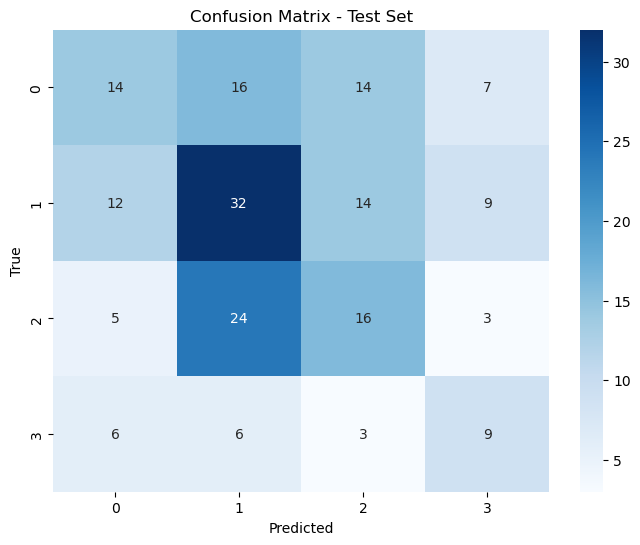

              precision    recall  f1-score   support

           0       0.38      0.27      0.32        51
           1       0.41      0.48      0.44        67
           2       0.34      0.33      0.34        48
           3       0.32      0.38      0.35        24

    accuracy                           0.37       190
   macro avg       0.36      0.37      0.36       190
weighted avg       0.37      0.37      0.37       190



In [13]:
mil_model.load_state_dict(torch.load("models/orc_mil_best.pth", map_location=device))
mil_model.eval()

test_preds = []
test_targets = []

test_loader = DataLoader(RAMDataset(test_data_ready), batch_size=1, shuffle=False, collate_fn=mil_collate)

with torch.no_grad():
    for batch_data in test_loader:
        feats = batch_data['features'].to(device)
        label = batch_data['label']
        
        logits, _ = mil_model(feats)
        test_preds.append(torch.argmax(logits).item())
        test_targets.append(label)

cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Test Set")
plt.show()

print(classification_report(test_targets, test_preds))

## 8. Visual Evidence: Attention Heatmaps

Visualizing reasons for prediction...
Patient: img_0745
True: 0, Predicted: 2


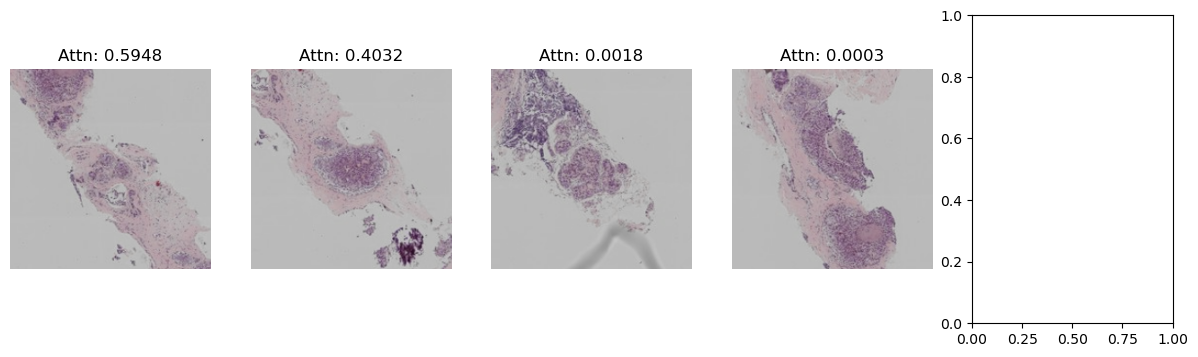

Patient: img_1352
True: 1, Predicted: 1


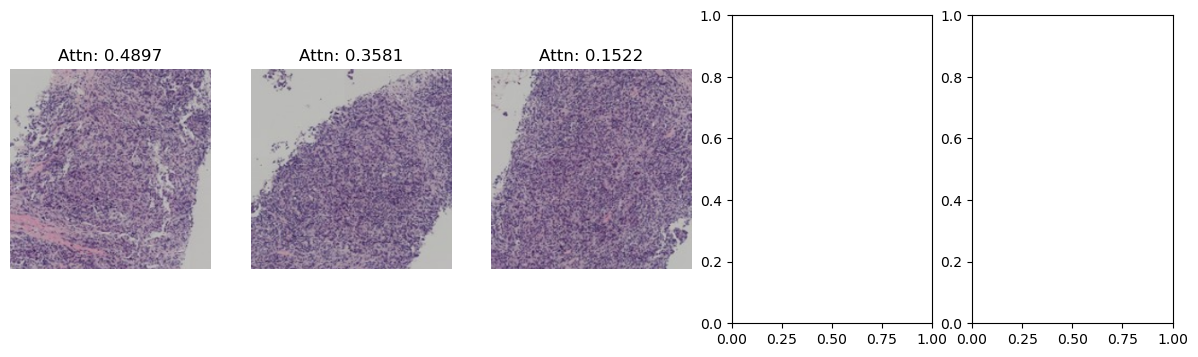

Patient: img_0079
True: 0, Predicted: 0


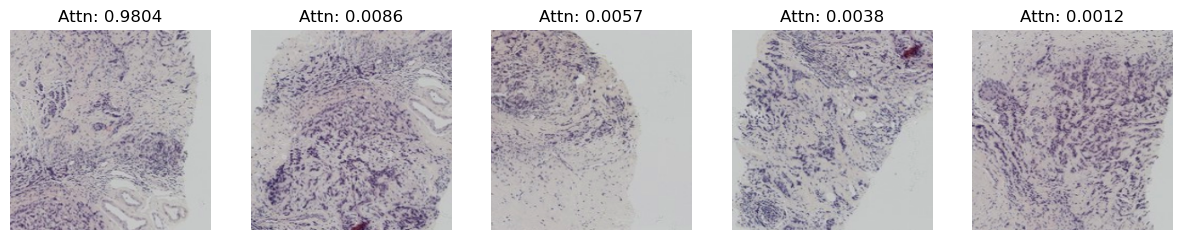

In [14]:
def visualize_patient_attention(patient_data, model, top_k=5):
    model.eval()
    with torch.no_grad():
        feats = patient_data['features'].to(device)
        logits, weights = model(feats)
        
    pred = torch.argmax(logits).item()
    true_label = patient_data['label']
    paths = patient_data['paths']
    
    print(f"Patient: {patient_data['id']}")
    print(f"True: {true_label}, Predicted: {pred}")
    
    weights = weights.cpu().numpy()
    top_indices = np.argsort(weights)[-top_k:][::-1]
    
    fig, axes = plt.subplots(1, top_k, figsize=(15, 4))
    for i, idx in enumerate(top_indices):
        img_path = paths[idx]
        score = weights[idx]
        img = Image.open(img_path)
        axes[i].imshow(img)
        axes[i].set_title(f"Attn: {score:.4f}")
        axes[i].axis('off')
    plt.show()

print("Visualizing reasons for prediction...")
for i in range(3):
    visualize_patient_attention(test_data_ready[i], mil_model)

In [15]:
# --- SUBMISSION GENERATION CELL ---

# 1. CONFIGURATION
# Update this path to where your test set patches are located
TEST_PATCHES_DIR = os.path.join(DATA_DIR, "test_patches") 
OUTPUT_CSV = "submission.csv"

# Re-create the inverse map to turn indices (0,1,2,3) back into names (Luminal A, etc.)
inverse_label_map = {v: k for k, v in label_map.items()}

print(f"Scanning test data in: {TEST_PATCHES_DIR}")

# 2. GROUPING (Bag Creation)
# We must group individual patch files by Patient ID
test_files = glob.glob(os.path.join(TEST_PATCHES_DIR, "*.png"))
test_bags = {}

for path in test_files:
    filename = os.path.basename(path)
    # Assuming standard format: PatientID_patchID.png
    # We split by '_' and take the first two parts to form the Patient ID
    patient_id = "_".join(filename.split("_")[:2])
    
    if patient_id not in test_bags:
        test_bags[patient_id] = []
    test_bags[patient_id].append(path)

print(f"Found {len(test_bags)} unique patients (bags) in test set.")

# 3. INFERENCE LOOP
# Ensure models are in eval mode and on device
feature_extractor.to(device)
feature_extractor.eval()
mil_model.to(device)
mil_model.eval()

submission_data = []

print("Running Inference (Feature Extraction + Attention MIL)...")
with torch.no_grad():
    for patient_id, bag_paths in tqdm(test_bags.items(), desc="Processing Patients"):
        
        # --- A. Feature Extraction (Phase 2 logic) ---
        images = []
        for p in bag_paths:
            try:
                img = Image.open(p).convert('RGB')
                img = val_transform(img) # Use the same transform as Validation
                images.append(img)
            except:
                pass # Skip broken images
        
        if len(images) == 0:
            print(f"Warning: Bag {patient_id} is empty.")
            continue
            
        # Stack images into a tensor
        img_batch = torch.stack(images).to(device)
        
        # If bag is too large, split it to avoid OOM
        if len(img_batch) > 128:
            features_list = []
            for split in torch.split(img_batch, 128):
                f = feature_extractor(split)
                features_list.append(f)
            bag_features = torch.cat(features_list)
        else:
            bag_features = feature_extractor(img_batch)
            
        # --- B. MIL Prediction (Phase 3 logic) ---
        # bag_features shape: (Num_Patches, 1280)
        logits, _ = mil_model(bag_features)
        
        # Get class index with highest score
        pred_idx = torch.argmax(logits).item()
        
        # Map back to string label
        pred_label = inverse_label_map[pred_idx]
        
        submission_data.append({'sample_index': patient_id + ".png", 'label': pred_label})


Scanning test data in: ..\an2dl2526c2\test_patches
Found 954 unique patients (bags) in test set.
Running Inference (Feature Extraction + Attention MIL)...


Processing Patients: 100%|██████████| 954/954 [00:29<00:00, 32.27it/s]


In [16]:
# 4. SAVE TO CSV
df_submission = pd.DataFrame(submission_data)

# Optional: Sort by ID for neatness
df_submission = df_submission.sort_values(by='sample_index')

df_submission.to_csv(OUTPUT_CSV, index=False)
print(f"Done! Submission saved to '{OUTPUT_CSV}'.")
print(df_submission.head())

Done! Submission saved to 'submission.csv'.
   sample_index      label
0  img_0000.png  Luminal B
1  img_0001.png  Luminal A
2  img_0002.png    HER2(+)
3  img_0003.png    HER2(+)
4  img_0004.png    HER2(+)
